In [40]:
import pandas as pd
from core.repository import load_financial
from base.timeutil import YearMonth
import sqlite3
from core.repository.maria.conn import maria_home

db_file = "analysis.db"

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(db_file))
except:
    print("Fetching month chart...")
    month_chart = pd.read_sql("""
        select month_chart.*, stock.name, stock.exchange from month_chart
        join stock on month_chart.code = stock.code;
    """, maria_home())
    print("Building layer1...")

    begin = YearMonth(2002, 4)
    end = YearMonth(2023, 5)

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.to(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
        df1 = df1[df1["val_last"] >= 1000_0000]

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
            "거래대금": df1["val"],
            "전월수익률": df1["close"] / df1["open"] - 1
        })

        shares = pd.concat([df1["shares"], df2["shares"]], axis=1)
        df = df.loc[shares.max(axis=1) / shares.min(axis=1) < 1.5]  # 액면분할 제거

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1
        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = layer1["확정실적"].apply(str)
    layer1.to_sql("layer1", sqlite3.connect(db_file), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,거래대금,...,E_QoQ,R/A_QoQ,GP/A_QoQ,O/A_QoQ,E/A_QoQ,R/EQ_QoQ,GP/EQ_QoQ,O/EQ_QoQ,E/EQ_QoQ,확정실적
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,5970,1480725,12071273140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,18050,706504,15311799550,...,2.151386,0.039735,0.013609,0.007998,0.012766,0.081359,0.027205,0.015848,0.025052,2001-4Q
2,054620,APS,코스닥,2002-04,2002-05,20934600000,2002-04-30,8510,3623832,41050604910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,-0.608231,-0.011676,-0.001393,0.003334,-0.017559,-0.014840,-0.001662,0.004425,-0.023219,2001-4Q
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,55800,4513180,263372467300,...,1.157134,0.248107,0.137269,0.058049,0.032612,0.635466,0.395791,0.181644,0.106711,2001-4Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389778,000547,흥국화재2우B,유가증권,2023-04,2023-05,2586624000,2023-04-28,16840,17229,302940060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
389779,000545,흥국화재우,유가증권,2023-04,2023-05,4308480000,2023-04-28,5610,60114,354420330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
389780,003280,흥아해운,유가증권,2023-04,2023-05,313994918094,2023-04-28,1306,4125665,5647897527,...,1.594315,0.060082,0.034251,0.019258,0.147371,0.134590,0.079402,0.044315,0.351282,2022-4Q
389781,037440,희림,코스닥,2023-04,2023-05,127947545250,2023-04-28,9190,9996877,94134547270,...,-0.651662,-0.062832,-0.013738,-0.005351,-0.015346,-0.128576,-0.032276,-0.011413,-0.041496,2022-4Q


In [41]:
import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "거래대금": "TV",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출액": "R",
        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = [
    "BIS",
    "BIS_QoQ",
    "전월수익률",
    "E_YoY",
    "O_YoY"
]

for x in ["R", "GP", "O", "E"]:
    for y in ["", "/A", "/EQ"]:
        factors.append(f"{x}{y}_QoQ")

for pos in ["R", "GP", "O", "E", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["A", "EQ"]:
    for pos in ["R", "GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

layer2["TV/P"] = layer2["TV"] / layer2["P"]
factors.append("TV/P")

result = pd.DataFrame()

recipes = {
    "v3": {
        "P": -8,
        "GP/P": 4,
        "EQ/P": 4,
        "R_QoQ": 1,
        "GP_QoQ": 1,
        "O_QoQ": 1,
        "E_QoQ": 1,
        "R/A_QoQ": 1,
        "GP/A_QoQ": 1,
        "O/A_QoQ": 1,
        "E/A_QoQ": 1
    },
    "성장_단순이익": {f"{e}_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자산대비이익": {f"{e}/A_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_자본대비이익": {f"{e}/EQ_QoQ": 1 for e in ["R", "GP", "O", "E"]},
    "성장_매출종합": {f"R{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_매출총이익종합": {f"GP{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_영업이익종합": {f"O{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_순이익종합": {f"E{b}_QoQ": 1 for b in ["", "/A", "/EQ"]},
    "성장_YoY": {"E_YoY": 1, "O_YoY": 1},
    "성장": {
        "성장_매출총이익종합": 5,
        "성장_영업이익종합": 4,
        "성장_순이익종합": 3,
        "성장_매출종합": 2,
    },
    "벨류": {
        "GP/P": 1,
        "EQ/P": 1,
    },
    "v4": {
        "P": -1,
        "성장": 1,
        "벨류": 1,
    },
    "전략": {
        "v3": 1,
        "v4": 1
    }
}

print(pd.DataFrame(recipes))

for ym in layer2["매수년월"].unique():
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for title, recipe in recipes.items():
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else -df[f"{k}_pct"] * abs(w) for k, w in recipe.items()])

        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[title] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{title}_pct"] = np.ceil(df[title].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

factors = list(recipes.keys()) + factors
result

             v3  성장_단순이익  성장_자산대비이익  성장_자본대비이익  성장_매출종합  성장_매출총이익종합  \
P          -8.0      NaN        NaN        NaN      NaN         NaN   
GP/P        4.0      NaN        NaN        NaN      NaN         NaN   
EQ/P        4.0      NaN        NaN        NaN      NaN         NaN   
R_QoQ       1.0      1.0        NaN        NaN      1.0         NaN   
GP_QoQ      1.0      1.0        NaN        NaN      NaN         1.0   
O_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
E_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
R/A_QoQ     1.0      NaN        1.0        NaN      1.0         NaN   
GP/A_QoQ    1.0      NaN        1.0        NaN      NaN         1.0   
O/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
E/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
R/EQ_QoQ    NaN      NaN        NaN        1.0      1.0         NaN   
GP/EQ_QoQ   NaN      NaN        NaN        1.0      NaN         1.0   
O/EQ_Q

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,TV,...,성장_YoY,성장_YoY_pct,성장,성장_pct,벨류,벨류_pct,v4,v4_pct,전략,전략_pct
0,060310,3S,코스닥,2002-04,2002-05,14328000000,2002-04-30,5970,1480725,12071273140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,006840,AK홀딩스,유가증권,2002-04,2002-05,108300000000,2002-04-30,18050,706504,15311799550,...,70.5,74.0,73.500000,83.0,54.5,55.0,19.666667,55.0,51.5,51.0
2,054620,APS,코스닥,2002-04,2002-05,20934600000,2002-04-30,8510,3623832,41050604910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001460,BYC,유가증권,2002-04,2002-05,38413822500,2002-04-30,61500,73712,5506711000,...,53.0,53.0,50.214286,51.0,93.5,96.0,31.333333,75.0,76.0,77.0
4,001040,CJ,유가증권,2002-04,2002-05,1250135164800,2002-04-30,55800,4513180,263372467300,...,99.5,100.0,96.857143,100.0,66.5,70.0,24.333333,63.0,60.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389778,000547,흥국화재2우B,유가증권,2023-04,2023-05,2586624000,2023-04-28,16840,17229,302940060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389779,000545,흥국화재우,유가증권,2023-04,2023-05,4308480000,2023-04-28,5610,60114,354420330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389780,003280,흥아해운,유가증권,2023-04,2023-05,313994918094,2023-04-28,1306,4125665,5647897527,...,85.5,88.0,94.357143,98.0,27.5,24.0,15.666667,46.0,45.0,45.0
389781,037440,희림,코스닥,2023-04,2023-05,127947545250,2023-04-28,9190,9996877,94134547270,...,62.0,65.0,33.214286,26.0,36.5,34.0,4.000000,25.0,27.0,27.0


['v3', '성장_단순이익', '성장_자산대비이익', '성장_자본대비이익', '성장_매출종합', '성장_매출총이익종합', '성장_영업이익종합', '성장_순이익종합', '성장_YoY', '성장', '벨류', 'v4', '전략']
[13/13] 전략YoY종합합합
2002-04 2023-05
             v3  성장_단순이익  성장_자산대비이익  성장_자본대비이익  성장_매출종합  성장_매출총이익종합  \
P          -8.0      NaN        NaN        NaN      NaN         NaN   
GP/P        4.0      NaN        NaN        NaN      NaN         NaN   
EQ/P        4.0      NaN        NaN        NaN      NaN         NaN   
R_QoQ       1.0      1.0        NaN        NaN      1.0         NaN   
GP_QoQ      1.0      1.0        NaN        NaN      NaN         1.0   
O_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
E_QoQ       1.0      1.0        NaN        NaN      NaN         NaN   
R/A_QoQ     1.0      NaN        1.0        NaN      1.0         NaN   
GP/A_QoQ    1.0      NaN        1.0        NaN      NaN         1.0   
O/A_QoQ     1.0      NaN        1.0        NaN      NaN         NaN   
E/A_QoQ     1.0      NaN        1.0        NaN      NaN  

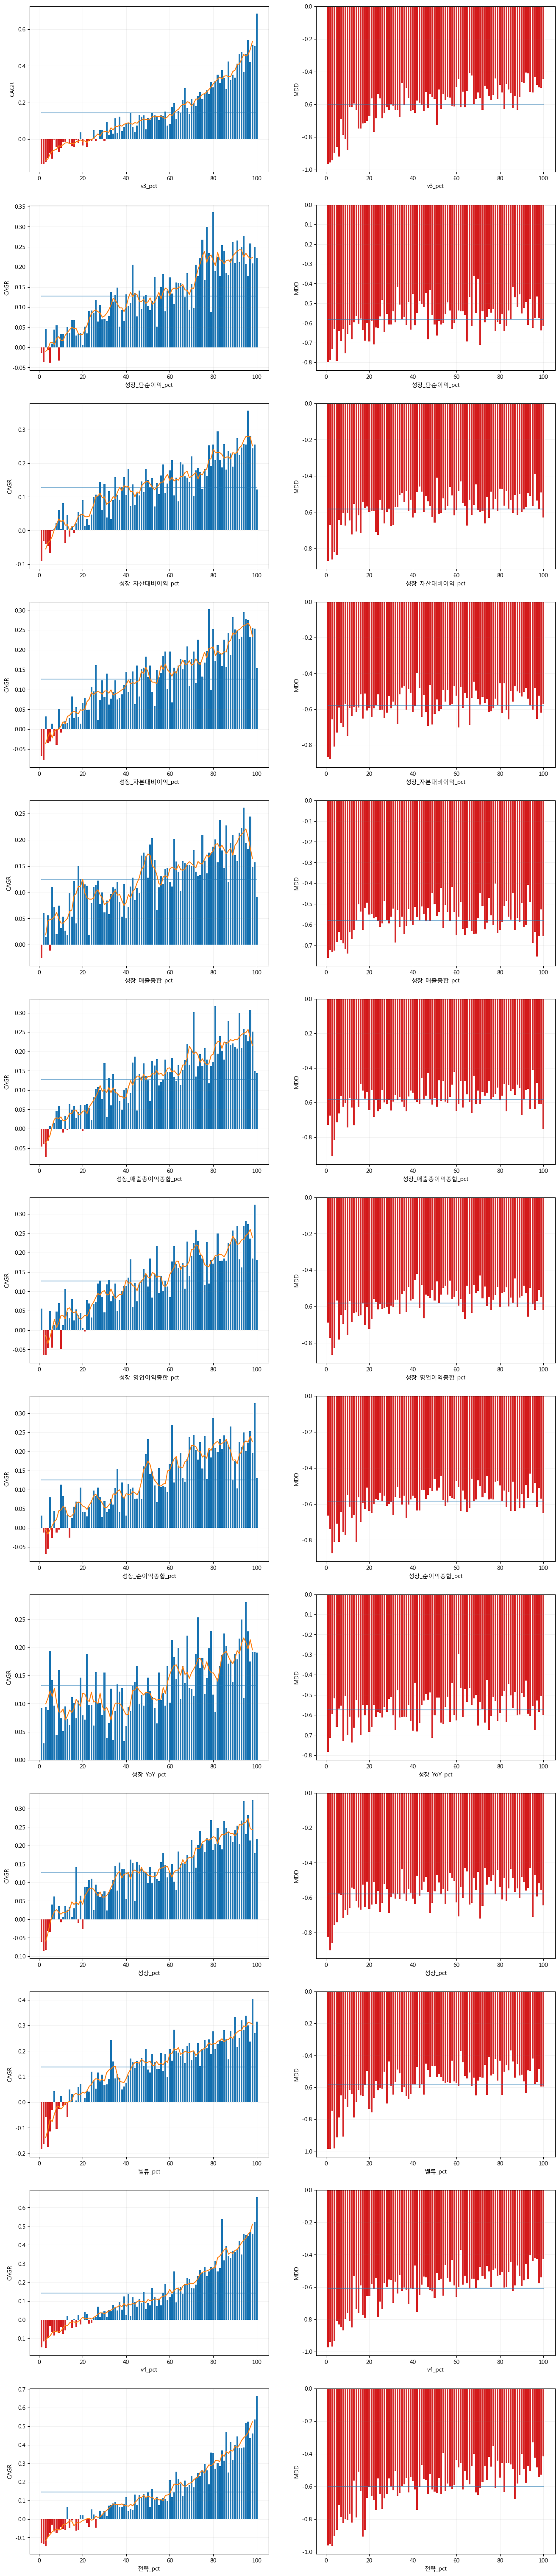

In [42]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

# target_factors = [f for f in factors if "성장" in f]
target_factors = list(recipes.keys())
print(target_factors)

fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    factor = target_factors[i]
    print(f"\r[{i + 1}/{len(target_factors)}] {factor}", end="")
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    spearman = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    kendall = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="kendall")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": spearman[colname_pct]["cagr"],
            "kendall": kendall[colname_pct]["cagr"],

            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),

            "t3": cagr_by_pct_desc.tail(3).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "t10": cagr_by_pct_desc.tail(10).mean(),

            "mdd5": mdd_by_pct_desc.head(5).mean(),

            "h3-t3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean(),
            "h10-t10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean(),

            "h3-t3+mdd3": cagr_by_pct_desc.head(3).mean() - cagr_by_pct_desc.tail(3).mean() + mdd_by_pct_desc.head(
                3).mean(),
            "h10-t10+mdd10": cagr_by_pct_desc.head(10).mean() - cagr_by_pct_desc.tail(10).mean() + mdd_by_pct_desc.head(
                10).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
        }).to_frame(factor).T
    ])

fig.savefig('test.png', bbox_inches='tight')

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

In [43]:
# 각 월에 전략에 의해 선정된 종목의 수익률이 과거 전략 매수에 의한 수익률과 어떤 관계를 갖는지 확인
# 결론: 의미 없는것 같음

search_result = result.copy()
search_result = search_result[search_result["전략_pct"] >= 99]
search_result = search_result[["code", "종목명", "매도년월", "전략_pct", "벨류_pct", "성장_pct", "수익률"]]


def historical_returns(row):
    selector = (search_result["매도년월"] < row["매도년월"]) & (search_result["code"] == row["code"])
    return (search_result[selector]["수익률"] + 1).prod()


# effect 는 선정된 각 종목의 과거 전략에 의한 수익률이다.
search_result["effect"] = search_result.apply(lambda row: historical_returns(row), axis=1)
search_result["벤치마크 수익률"] = (result.groupby("매도년월")["수익률"]).transform('mean')
search_result["성능"] = search_result["수익률"] - search_result["벤치마크 수익률"]
data = search_result.groupby("code")["성능"].mean()
print("out count", data[data > 0].count())
print("und count", data[data < 0].count())
print("out 성능평균", data[data > 0].mean())
print("und 성능평균", data[data < 0].mean())

out count 441
und count 164
out 성능평균 0.09686234054181533
und 성능평균 -0.03579950678903815


In [44]:
# 백테스트: 매매 시뮬레이션

from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "전략"
print(factor)

head = 20
result2 = result.copy()
result2 = result2[~result2["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["R/A_pct"] > 10]
result2 = result2[result2["GP/A_pct"] > 10]
result2 = result2[result2["O/A_pct"] > 10]
result2 = result2[result2["E/A_pct"] > 10]
result2 = result2[result2["R/EQ_pct"] > 10]
result2 = result2[result2["GP/EQ_pct"] > 10]
result2 = result2[result2["O/EQ_pct"] > 10]
result2 = result2[result2["E/EQ_pct"] > 10]

# todo: 필터를 전 종목 기준으로 하지말고, 전략 내에서 해보자. 예를들면, 전월수익률

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})

def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

result3 = result2.groupby(_key).apply(
    lambda x: x.sort_values(factor, ascending=False).head(head).sort_values("수익률", ascending=False))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", "전월수익률", "P_pct", "성장_pct", "벨류_pct", f"{factor}_pct"]]
result3.to_csv("result3-2.csv")

result3

전략
          CAGR                                        MDD      Mean
전략    0.652268  (-0.4719080709525403, (2007-09, 2008-10))  0.046434
벤치마크  0.135650  (-0.5447610802090497, (2007-07, 2008-10))  0.012978


code        종목명       수익률   거래소         매수일  \
매수년월    매도년월                                                            
2002-04 2002-05 261     012510      더존비즈온  4.506944  유가증권  2002-04-30   
                638     014990       인디에프  0.542857  유가증권  2002-04-30   
                114     005610      SPC삼립  0.219479  유가증권  2002-04-30   
                484     005390       신성통상  0.129032  유가증권  2002-04-30   
                374     003960       사조대림  0.060606  유가증권  2002-04-30   
...                        ...        ...       ...   ...         ...   
2023-04 2023-05 389201  066360       체리부로  0.010484   코스닥  2023-04-28   
                389576  080720    한국유니온제약 -0.050000   코스닥  2023-04-28   
                388760  323230    엠에프엠코리아 -0.051282   코스닥  2023-04-28   
                389228  001620  케이비아이동국실업 -0.163895  유가증권  2023-04-28   
                387445  044180         KD -0.222028   코스닥  2023-04-28   

                               매도일   매수가      매도가     전월수익률  P_pct  성장_pct  \
매수년월    매도년월                                                                 
2002-04 2002-05 261     2002-05-31   720   3965.0 -0.923404    6.0   100.0   
                638     2002-05-31  7000  10800.0  0.666667   31.0    98.0   
                114     2002-05-31  7290   8890.0 -0.232632    2.0    51.0   
                484     2002-05-31  3100   3500.0 -0.034268   17.0    90.0   
                374     2002-05-31  5280   5600.0 -0.127273    7.0    86.0   
...                            ...   ...      ...       ...    ...     ...   
2023-04 2023-05 389201  2023-05-31  1240   1253.0 -0.007206   19.0    94.0   
                389576  2023-05-31  6000   5700.0  0.025641   14.0    99.0   
                388760  2023-05-31   819    777.0 -0.057537    4.0    98.0   
                389228  2023-05-31   842    704.0  0.277693   32.0   100.0   
                387445  2023-05-31  1144    890.0  0.851133    5.0    99.0   

                        벨류_pct  전략_pct  
매수년월    매도년월                            
2002-04 2002-05 261       60.0    99.0  
                638       85.0    97.0  
                114      100.0    98.0  
                484      100.0    99.0  
                374      100.0   100.0  
...                        ...     ...  
2023-04 2023-05 389201    85.0   100.0  
                389576    70.0   100.0  
                388760    80.0   100.0  
                389228    87.0   100.0  
                387445    76.0   100.0  

[5060 rows x 13 columns]

In [45]:
pd.concat([
    revisions,
    revisions["성능"].rolling(12).apply(lambda x: round((x + 1).prod() - 1, 2)).rename("성능 12개월"),
    revisions["전략 수익률"].rolling(12).apply(lambda x: round((x + 1).prod() - 1, 2)).rename("전략수익률 12개월")
], axis=1)

,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률,성능 12개월,전략수익률 12개월
매수년월,매도년월,,,,,,,
2002-04,2002-05,-0.043962,0.255834,0.30,0.956038,1.255834,NaN,NaN
2002-05,2002-06,-0.105127,-0.106996,-0.00,0.855533,1.121465,NaN,NaN
2002-06,2002-07,-0.002023,0.048928,0.05,0.853803,1.176336,NaN,NaN
2002-07,2002-08,0.034301,0.065608,0.03,0.883089,1.253512,NaN,NaN
2002-08,2002-09,-0.150058,-0.038575,0.11,0.750575,1.205158,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-12,2023-01,0.094020,0.125401,0.03,13.733063,37747.428515,0.40,0.30
2023-01,2023-02,0.018158,0.030874,0.01,13.982422,38912.833551,0.40,0.29
2023-02,2023-03,0.011559,-0.009235,-0.02,14.144041,38553.482328,0.32,0.14


전체 개월 수       253.00000
초과수익 개월 수     184.00000
누적 성능        3090.02526
dtype: float64

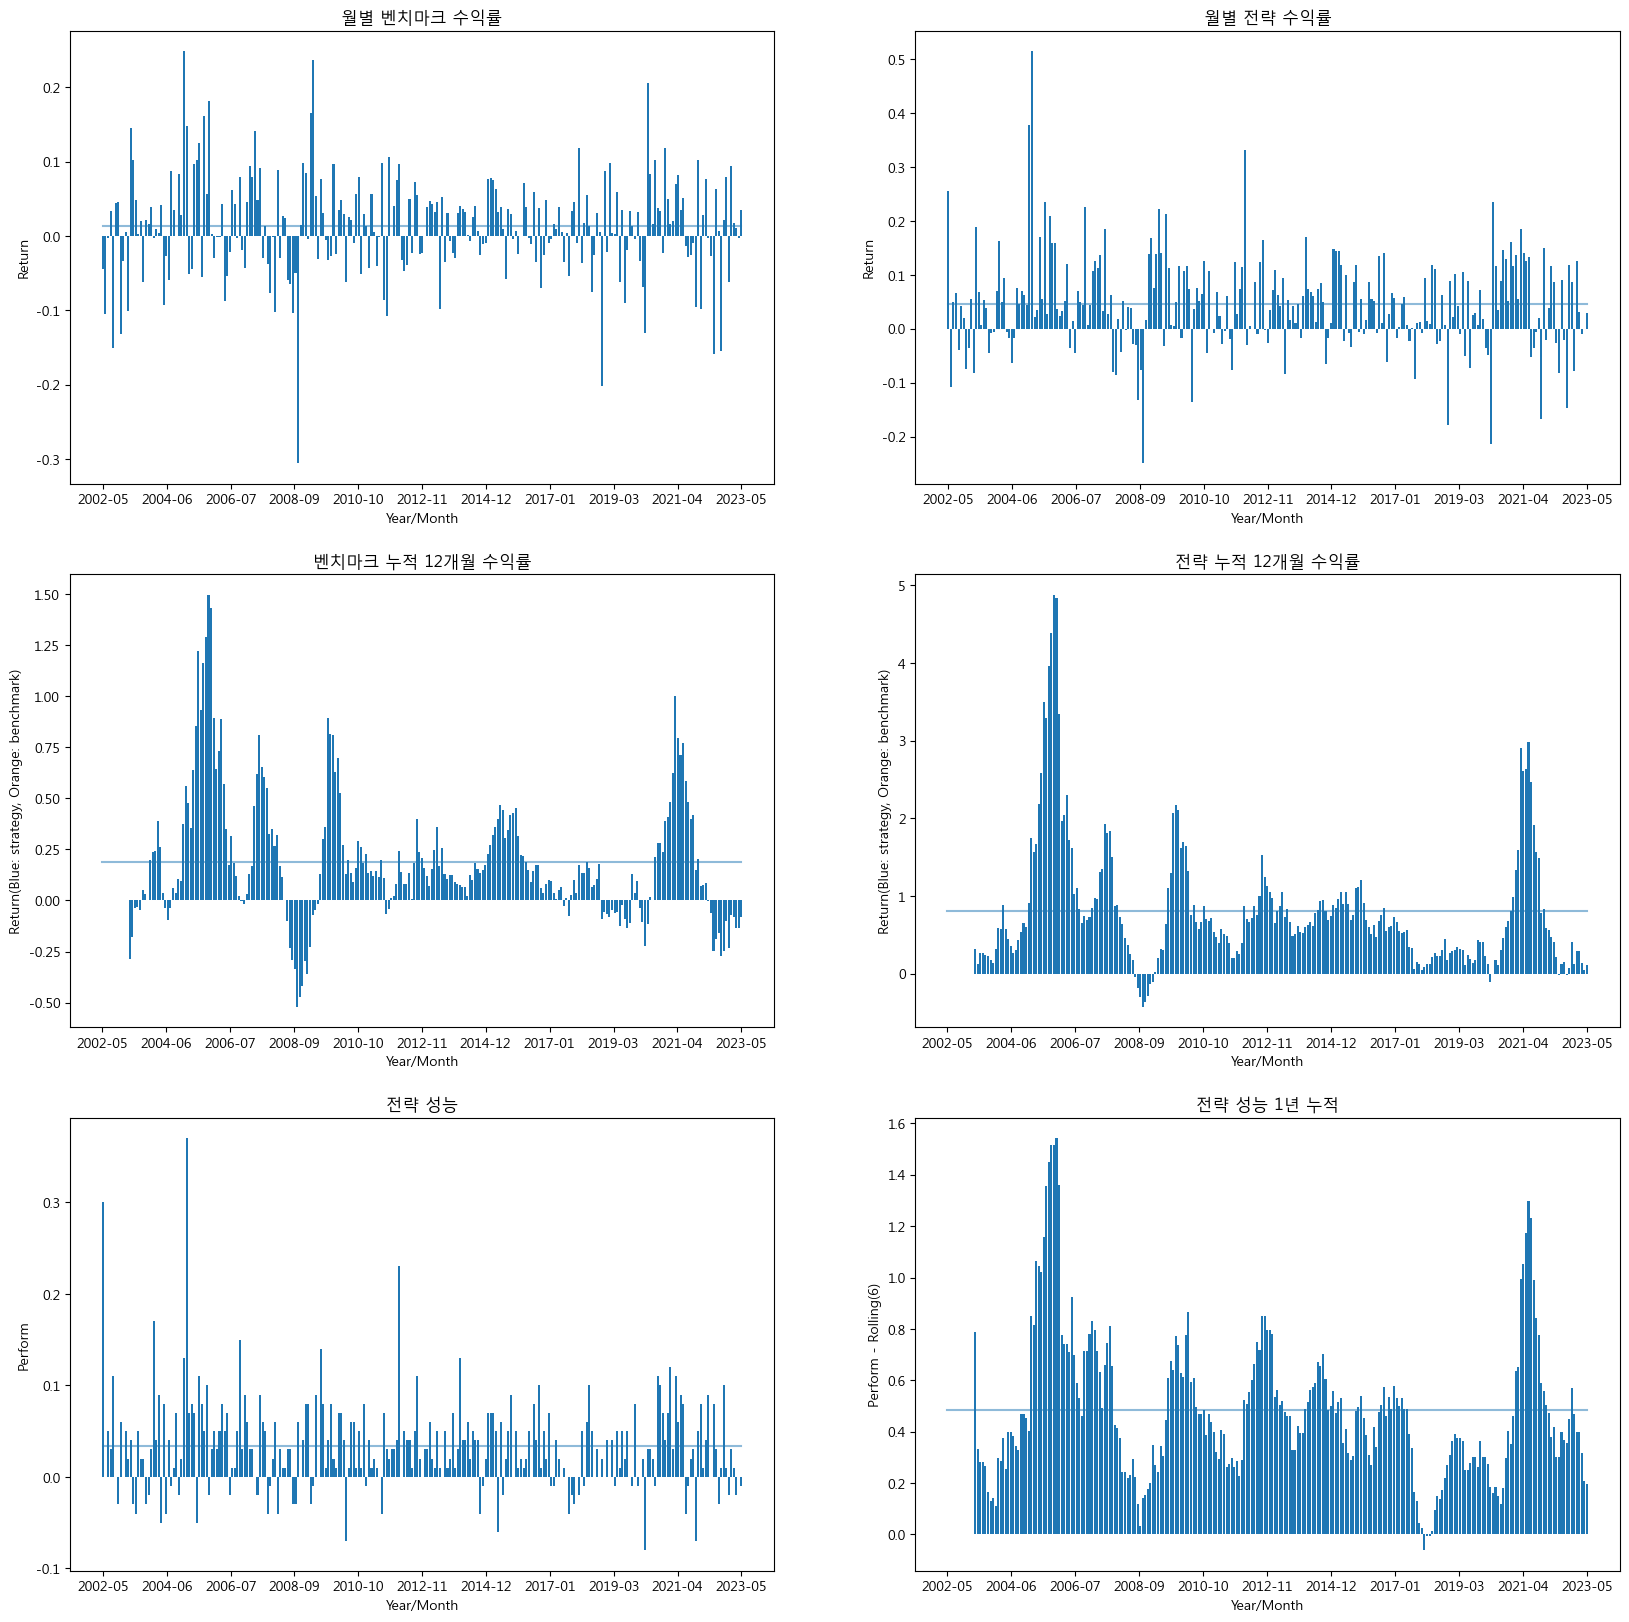

In [46]:
import numpy as np
import matplotlib.pyplot as plt

months = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"월별 벤치마크 수익률")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])
ax1.plot(months, [revisions["벤치마크 수익률"].mean()] * len(months), alpha=0.5)

ax2.set_title("월별 전략 수익률")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["전략 수익률"])
ax2.plot(months, [revisions["전략 수익률"].mean()] * len(months), alpha=0.5)

ax3.set_title(f"벤치마크 누적 12개월 수익률")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["벤치마크 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax3.bar(months, values)
ax3.plot(months, [values.mean()] * len(months), alpha=0.5)

ax4.set_title("전략 누적 12개월 수익률")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["전략 수익률"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax4.bar(months, values)
ax4.plot(months, [values.mean()] * len(months), alpha=0.5)

ax5.set_title("전략 성능")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["성능"])
ax5.plot(months, [revisions["성능"].mean()] * len(months), alpha=0.5)

ax6.set_title(f"전략 성능 1년 누적")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({6})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
values = revisions["성능"].rolling(12).apply(lambda x: (x + 1).prod() - 1)
ax6.bar(months, values)
ax6.plot(months, [values.mean()] * len(months), alpha=0.5)

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "누적 성능": (revisions["성능"] + 1).prod() - 1,
})